In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import json
from pathlib import Path
from pprint import pprint
from urllib.parse import urlparse
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

try:  # for notebooks
    get_ipython
    from tqdm._tqdm_notebook import tqdm_notebook as tqdm
except:  # for commandline
    from tqdm import tqdm
tqdm.pandas()

In [2]:
pd.set_option("display.precision", 2)
sns.set_style("darkgrid")

In [3]:
path_queries = Path("../../data/queries/")
path_relevant = Path("../../data/relevant/")
path_refetched = Path("../../data/refetched/")
path_final = Path("../../data/final/")

files = [f for f in listdir(str(path_relevant)) if isfile(join(str(path_relevant), f))]
files.remove("expanded_urls.csv")

In [4]:
def get_tweet_urls(t):
    '''
    Given a Tweet JSON, pull the URLs found inside it
    '''
    try:
        return get_urls(t['entities']['urls'])
    except:
        return []


def get_retweet_urls(t):
    '''
    Given a Tweet JSON, pull the URLs of the Tweet this tweet retweeted
    '''
    try:
        return get_urls(t['retweeted_status']['entities']['urls'])
    except:
        return []


def get_urls(urls):
    '''
    Generic function to extract the URLs from the urls sub-object
    '''
    try:
        urls = [v for (k, v) in urls[0].items()
                if k in ('url', 'expanded_url')]
        return list(set(urls))
    except:
        return []
    
def clean_url(url):
    '''
    Strip out trailing slashes, URL query variables, anchors, etc.
    '''
    if url:
        try:
            up = urlparse(url)
            domain = '.'.join(up.netloc.split('.')[-2:]).strip()
            path = up.path.strip('/').strip()
            return '{}/{}'.format(domain, path)
        except:
            raise
    else:
        return "None"
    
def get_domain(url):
    '''
    Strip out trailing slashes, URL query variables, anchors, etc.
    '''
    if url:
        try:
            up = urlparse(url)
            domain = '.'.join(up.netloc.split('.')[-2:]).strip()
            return domain
        except:
            raise
    else:
        return "None"
    
def load_urls(file):
    urls = pd.read_csv(file,
                       na_values="None",
                       dtype={'tweet_id': str,
                              'retweet_id':str,
                              'relevant_url':str,
                              'clean_url': str})
    urls = urls.drop_duplicates()
    urls = urls.set_index("tweet_id")
    return urls

def load_tweets(file):
    tweets = pd.read_csv(file,
                         dtype={'tweet_id':str,
                                'retweet_id':str},
                         parse_dates=['posted_on'])
    tweets = tweets.drop_duplicates(subset=["tweet_id", "posted_on"])
    tweets = tweets.set_index("tweet_id")
#     tweets['retweet_id'] = tweets.retweet_id.map(lambda x: np.nan if pd.isna(x) else int(x))
    return tweets

In [5]:
exp = pd.read_csv(path_relevant / "expanded_urls.csv")
exp.head()

,short_url,tweet_id,venue,resolved_url,error,timestamp
0,http://fb.me/30Syy2KtB,869663798558302210,slate,https://enjeuxenergies.wordpress.com/2017/05/3...,NaN,2018-09-20 15:25:50.979884
1,https://t.co/XNRoZBHuMk,869663798558302210,slate,https://enjeuxenergies.wordpress.com/2017/05/3...,NaN,2018-09-20 15:25:51.218138
2,http://fb.me/6x5jkOkzv,870945411476967424,slate,https://enjeuxenergies.wordpress.com/2017/06/0...,NaN,2018-09-20 15:25:51.480434
3,https://t.co/oalGK1etb6,870945411476967424,slate,https://enjeuxenergies.wordpress.com/2017/06/0...,NaN,2018-09-20 15:25:51.636100
4,http://fb.me/8BxHZiwA5,871096342226980864,slate,https://enjeuxenergies.wordpress.com/2017/06/0...,NaN,2018-09-20 15:25:51.845634


In [6]:
print("number of resolved URLs: ", len(exp))
print("number of errors:", exp.error.count())

number of resolved URLs:  1616036
number of errors: 14474


# Create final datasets



In [7]:
df = pd.DataFrame(columns=["retweets /w url", "retweets /wo url", "retweets /w added url", "missing original tweets", "rtwts in tweets", "rtwts in urls"])

for file in tqdm(files):
    if isfile(str(path_final / file)):
        print("{} already exists".format(file))
        continue
    urls = load_urls(path_relevant / file)
    tweets = load_tweets(path_refetched / file)

    urls = urls.merge(tweets[['retweet_id']], left_index=True, right_index=True, how="left", validate="one_to_one")
    urls['retweet_url'] = None
    
    rtwts_with_urls = urls[(urls.retweet_id.notnull()) & (urls.clean_url.notnull())].retweet_id
    rtwts_wo_urls = urls[(urls.retweet_id.notnull()) & (urls.clean_url.isnull())].retweet_id
        
     # Copy relevant urls for retweeted statuses from original ones
    for ix, row in urls[urls.retweet_id.isin(rtwts_wo_urls)].iterrows():
        rt_id = row['retweet_id']
        if rt_id in urls.index:
            if urls.loc[rt_id, 'clean_url']:
                urls.loc[ix, 'retweet_url'] = urls.loc[rt_id, 'clean_url']

    urls.to_csv(path_final / file, header=True)
#     df.loc[file] = [rtwts_with_urls.count(),
#                     rtwts_wo_urls.count(),
#                     urls.retweet_url.count(),
#                     rtwts_wo_urls.nunique(),
#                     tweets[tweets.index.isin(rtwts_wo_urls.unique())].shape[0],
#                     urls[urls.index.isin(rtwts_wo_urls.unique())].clean_url.count()]
# df

slate AND bad_astronomy.csv already exists
bostonglobe AND science_extended.csv already exists
slate AND climate_desk.csv already exists
slate AND future_tense.csv already exists
guardian AND science.csv already exists
chicago AND suntimes AND science.csv already exists
bostonglobe AND science.csv already exists
washingtonpost AND animalia.csv already exists
sfchronicle AND science.csv already exists
slate AND health_and_science.csv already exists
latimes AND science.csv already exists
theglobeandmail AND science.csv already exists



In [41]:
def merge_urls(row):
    a = row['clean_url']
    b = row['retweet_url']
    if not pd.isna(a):
        return a
    
    return b
        
# Look up individual tweets
venues = pd.DataFrame(columns=["total", "found",  "retweets", "unique_retweets", "found_retweets", "unique_urls"])
urls_dict = {}

for file in tqdm(files):
    urls = load_urls(path_final / file)

    urls['final_url'] = urls.apply(merge_urls, axis=1)
    
    v = file.split(" ")[0]
    if v in urls_dict:
        urls_dict[v] = urls_dict[v].union((urls['final_url'].dropna().tolist()))
    else:
        urls_dict[v] = set(urls['final_url'].dropna().tolist())
    
    rtwts_with_urls = urls[(urls.retweet_id.notnull()) & (urls.clean_url.notnull())].retweet_id
    rtwts_wo_urls = urls[(urls.retweet_id.notnull()) & (urls.clean_url.isnull())].retweet_id
    
    total = len(urls)
    found = urls.final_url.count()
    unique_urls = urls.final_url.nunique()
    retweets = urls.retweet_id.count()
    unique_retweets = urls.retweet_id.nunique()
    found_retweets = len(urls.index.unique().intersection(urls.retweet_id.dropna()))
    
    venues.loc[file] = [total, found, retweets, unique_retweets, found_retweets, unique_urls]
    
venues = venues.replace(0, np.nan)

In [9]:
summary = pd.DataFrame(columns=venues.columns)

for venue in venues.index.tolist():
    v = venue.split(" ")[0]
    summary.loc[v] = venues[venues.index.str.contains(v)].sum()
    
summary['found_%'] = 100 * summary.found.div(summary.total)
summary['retweet_%'] = 100 * summary.retweets.div(summary.found)
summary['found_retweets_%'] = 100 * summary.found_retweets.div(summary.retweets)
summary['urls_to_tweets_%'] = 100 * summary.unique_urls.div(summary.total)
summary['urls_to_og_tweets_%'] = 100 * summary.unique_urls.div(summary.total-summary.retweets)

summary.astype(float).round(2)

,total,found,retweets,unique_retweets,found_retweets,unique_urls,found_%,retweet_%,found_retweets_%,urls_to_tweets_%,urls_to_og_tweets_%
slate,1876.0,1715.0,982.0,162.0,965.0,311.0,91.42,57.26,98.27,16.58,34.79
bostonglobe,18802.0,17522.0,14220.0,1327.0,13540.0,920.0,93.19,81.16,95.22,4.89,20.08
guardian,79489.0,72533.0,36742.0,8236.0,35506.0,5019.0,91.25,50.66,96.64,6.31,11.74
chicago,832.0,818.0,564.0,73.0,563.0,63.0,98.32,68.95,99.82,7.57,23.51
washingtonpost,153393.0,145822.0,112309.0,7501.0,110141.0,1647.0,95.06,77.02,98.07,1.07,4.01
sfchronicle,9879.0,9417.0,7004.0,820.0,6992.0,490.0,95.32,74.38,99.83,4.96,17.04
latimes,126484.0,122780.0,72216.0,8988.0,70087.0,3886.0,97.07,58.82,97.05,3.07,7.16
theglobeandmail,26203.0,25546.0,18076.0,2181.0,17961.0,825.0,97.49,70.76,99.36,3.15,10.15


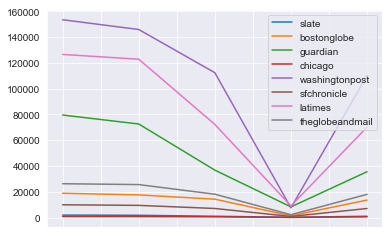

In [10]:
cols = ['total', 'found', 'retweets', 'unique_retweets', 'found_retweets']
summary[cols].T.plot()

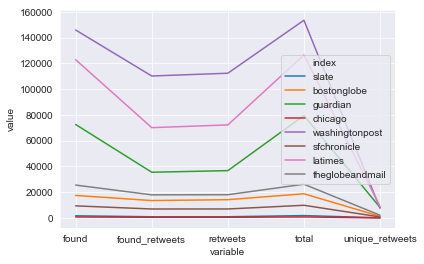

In [158]:
pdf = summary[cols].reset_index().melt(id_vars="index", value_vars=cols)
sns.lineplot(x="variable", y="value", hue="index", data=pdf)

In [11]:
summary[cols]

,total,found,retweets,unique_retweets,found_retweets
slate,1876.0,1715.0,982.0,162.0,965.0
bostonglobe,18802.0,17522.0,14220.0,1327.0,13540.0
guardian,79489.0,72533.0,36742.0,8236.0,35506.0
chicago,832.0,818.0,564.0,73.0,563.0
washingtonpost,153393.0,145822.0,112309.0,7501.0,110141.0
sfchronicle,9879.0,9417.0,7004.0,820.0,6992.0
latimes,126484.0,122780.0,72216.0,8988.0,70087.0
theglobeandmail,26203.0,25546.0,18076.0,2181.0,17961.0


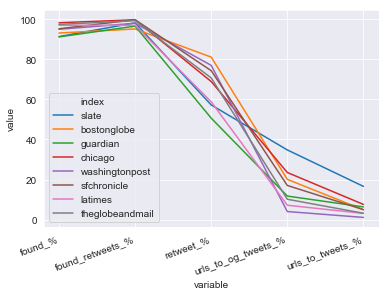

In [12]:
cols = ['found_%', 'retweet_%', 'found_retweets_%', 'urls_to_tweets_%', 'urls_to_og_tweets_%']
pdf = summary[cols].reset_index().melt(id_vars="index", value_vars=cols)
ax = sns.lineplot(x="variable", y="value", hue="index", data=pdf)
plt.xticks(rotation=20, ha="right");

## Altmetric mentions

In [54]:
match_news = {
    'latimes': 'LA Times',
    'sfchronicle': 'San Francisco Chronicle',
    'chicago': 'Chicago Sun-Times', 
    'theglobeandmail': 'The Globe and Mail', 
    'washingtonpost': 'Washington Post', 
    'bostonglobe': 'The Boston Globe',
    'slate': 'Slate Magazine', 
    'guardian': 'The Guardian'
}

In [42]:
urls_dict.keys()

dict_keys(['latimes', 'sfchronicle', 'chicago', 'theglobeandmail', 'washingtonpost', 'bostonglobe', 'slate', 'guardian'])

In [49]:
am.Author_name.unique()

array(['New York Times', 'The Guardian', 'LA Times', 'Washington Post',
       'FOX News', 'Slate France', 'The Boston Globe', 'Wired.it',
       'Wired.co.uk', 'Slate Magazine', 'The Globe and Mail',
       'San Francisco Chronicle', 'Wired.com', 'Chicago Sun-Times'], dtype=object)

In [125]:
news_short_altmetric = {
    'bostonglobe': ['The Boston Globe'],
    'chicago': ['Chicago Sun-Times'], 
    'foxnews': ['FOX News'],
    'guardian': ['The Guardian'],
    'iflscience': [],
    'latimes': ['LA Times'],
    'nytimes': ['New York Times'],
    'sfchronicle': ['San Francisco Chronicle'],
    'slate': ['Slate Magazine', 'Slate France'], 
    'theglobeandmail': ['The Globe and Mail'], 
    'washingtonpost': ['Washington Post'],
    'wired': ['Wired.it', 'Wired.com', 'Wired.co.uk']
}

news_altmetric_short = {}
for a,ss in news_short_altmetric.items():
    for s in ss:
        news_altmetric_short[s] = a

In [134]:
# compare urls
am_news_mentions = pd.read_excel("../../data/NewsMentions-AltmetricOct2017.xlsx", sheet_name=1, index_col="Altmetric_ID", parse_dates=['Posted_On'])
am_news_mentions.index.name = 'altmetric_id'
am_news_mentions.rename(columns={'Author_name': 'venue_name',
                   'Url': 'altmetric_url',
                   'Author_Url': 'venue_url',
                   'Posted_On': 'posted_on'}, inplace=True)
am_news_mentions['venue_short'] = am_news_mentions['venue_name'].map(lambda x: news_altmetric_short[x])
am_news_mentions.to_csv("../../data/news_mentions.csv")
am_news_mentions.head()

,venue_name,altmetric_url,venue_url,posted_on,venue_short
altmetric_id,,,,,
12342309,New York Times,http://ct.moreover.com/?a=28136727855&p=1pl&v=...,http://www.nytimes.com/,2016-10-01 04:00:00,nytimes
12107072,New York Times,http://ct.moreover.com/?a=28135565677&p=1pl&v=...,http://www.nytimes.com/,2016-10-01 04:00:00,nytimes
19509585,The Guardian,http://ct.moreover.com/?a=28137724207&p=1pl&v=...,http://www.guardian.co.uk/,2016-10-01 05:00:10,guardian
3711493,LA Times,http://ct.moreover.com/?a=28140151316&p=1pl&v=...,http://www.latimes.com,2016-10-01 11:33:36,latimes
4826457,Washington Post,https://www.washingtonpost.com/national/health...,http://www.washingtonpost.com,2016-10-01 11:34:52,washingtonpost


In [152]:
am_news_urls = am_news_mentions.drop_duplicates()
am_news_urls = am_news_urls.reset_index()
del am_news_urls['altmetric_id']
am_news_urls = am_news_urls.assign(resolve_url=np.nan, resolve_error=np.nan)
am_news_urls.head()

,venue_name,altmetric_url,venue_url,posted_on,venue_short,resolve_error,resolve_url
0,New York Times,http://ct.moreover.com/?a=28136727855&p=1pl&v=...,http://www.nytimes.com/,2016-10-01 04:00:00,nytimes,NaN,NaN
1,New York Times,http://ct.moreover.com/?a=28135565677&p=1pl&v=...,http://www.nytimes.com/,2016-10-01 04:00:00,nytimes,NaN,NaN
2,The Guardian,http://ct.moreover.com/?a=28137724207&p=1pl&v=...,http://www.guardian.co.uk/,2016-10-01 05:00:10,guardian,NaN,NaN
3,LA Times,http://ct.moreover.com/?a=28140151316&p=1pl&v=...,http://www.latimes.com,2016-10-01 11:33:36,latimes,NaN,NaN
4,Washington Post,https://www.washingtonpost.com/national/health...,http://www.washingtonpost.com,2016-10-01 11:34:52,washingtonpost,NaN,NaN


In [60]:
for short, long in match_news.items():
    tw = len(urls_dict[short])
    am = len(am_urls[long])
    both = len(urls_dict[short].intersection(am_urls[long]))
    print("{}:\t\ttwitter: {}, altmetric: {}, both: {}".format(short, tw, am, both))

latimes:		twitter: 3886, altmetric: 5, both: 4
sfchronicle:		twitter: 490, altmetric: 3, both: 0
chicago:		twitter: 63, altmetric: 1, both: 0
theglobeandmail:		twitter: 825, altmetric: 198, both: 37
washingtonpost:		twitter: 1647, altmetric: 1328, both: 41
bostonglobe:		twitter: 803, altmetric: 2, both: 0
slate:		twitter: 311, altmetric: 1, both: 0
guardian:		twitter: 5019, altmetric: 6, both: 1


In [156]:
def resolve_url(url, session, timeout=10):
    try:
        resp = session.head(url, allow_redirects=True, timeout=timeout)
        return resp.url, None
    except Exception as e:
        return None, e

In [154]:
am_unique['resolved_url'] = None
am_unique['resolve_error'] = None

df = am_news_urls.sample(100)

session = requests.Session()
for index, row in tqdm(df.iterrows(), total=len(df)):
    if 'moreover' in row['altmetric_url']:
        url, e = resolve_url(row['altmetric_url'], session)
        df.loc[row.name, 'resolve_url'] = url
        df.loc[row.name, 'resolve_error'] = e

In [161]:
def choose_url(row):
    if 'moreover' in row['altmetric_url']:
        return row['resolve_url']
    else:
        return row['altmetric_url']
df['url'] = df.apply(choose_url, axis=1)

In [169]:
clean_urls = pd.DataFrame(columns=["twitter_urls", "am_urls", "match"])

for file in tqdm(files):        
    urls = load_urls(path_final / file)
    
    dom = file.split(" ")[0]
    k = None
    for d in am.domain.value_counts().keys():
        if dom in d:
            k = d
    
    twitter_total = urls.clean_url.count()
    twitter_urls = urls.clean_url.unique().tolist()
    
    if k:
        am_total = am.domain.value_counts()[k]
        am_urls = am[am.domain.str.contains(k)].clean_url.unique().tolist()
    else:
        am_total = None
        am_urls = []
        
    match = len(set(twitter_urls).intersection(set(am_urls)))
    if match == 0:
        match = None

    clean_urls.loc[file] = [len(twitter_urls), len(am_urls), match]
    
clean_urls['twitter_%'] = 100 * clean_urls.match.div(clean_urls.twitter_urls)
clean_urls['am_%'] = 100 * clean_urls.match.div(clean_urls.am_urls)

clean_urls.astype(float).round(2)

,twitter_urls,am_urls,match,twitter_%,am_%
slate AND bad_astronomy.csv,107.0,1.0,NaN,NaN,NaN
bostonglobe AND science_extended.csv,119.0,2.0,NaN,NaN,NaN
slate AND climate_desk.csv,2.0,1.0,NaN,NaN,NaN
slate AND future_tense.csv,179.0,1.0,NaN,NaN,NaN
guardian AND science.csv,5020.0,9.0,2.0,0.04,22.22
chicago AND suntimes AND science.csv,64.0,0.0,NaN,NaN,NaN
bostonglobe AND science.csv,803.0,2.0,NaN,NaN,NaN
washingtonpost AND animalia.csv,1648.0,1352.0,46.0,2.79,3.40
sfchronicle AND science.csv,491.0,2.0,NaN,NaN,NaN
slate AND health_and_science.csv,27.0,1.0,NaN,NaN,NaN
